In [6]:
import io

import clip  # CLIP model
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from EfficientSAM.efficient_sam.efficient_sam import build_efficient_sam
from PIL import Image
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)
from torchvision.ops.boxes import batched_nms, box_area
from torchvision.transforms import ToTensor

torch.set_grad_enabled(False)

def build_efficient_sam_vitt(device='cpu'):
    return build_efficient_sam(
        encoder_patch_embed_dim=192,
        encoder_num_heads=3,
        checkpoint="EfficientSAM/weights/efficient_sam_vitt.pt",
    ).eval()

def build_efficient_sam_vits(device='cpu'):
    return build_efficient_sam(
        encoder_patch_embed_dim=384,
        encoder_num_heads=6,
        checkpoint="EfficientSAM/weights/efficient_sam_vits.pt",
    ).eval()

def process_small_region(rles):
    # Function as before to remove small regions
    new_masks = []
    scores = []
    min_area = 100
    nms_thresh = 0.7
    for rle in rles:
        mask = rle_to_mask(rle[0])
        mask, changed = remove_small_regions(mask, min_area, mode="holes")
        unchanged = not changed
        mask, changed = remove_small_regions(mask, min_area, mode="islands")
        unchanged = unchanged and not changed

        new_masks.append(torch.as_tensor(mask).unsqueeze(0))
        scores.append(float(unchanged))

    # Recalculate boxes and remove duplicates using NMS
    masks = torch.cat(new_masks, dim=0)
    boxes = batched_mask_to_box(masks)
    keep_by_nms = batched_nms(
        boxes.float(),
        torch.as_tensor(scores),
        torch.zeros_like(boxes[:, 0]),
        iou_threshold=nms_thresh,
    )

    # Recalculate RLEs for changed masks
    for i_mask in keep_by_nms:
        if scores[i_mask] == 0.0:
            mask_torch = masks[i_mask].unsqueeze(0)
            rles[i_mask] = mask_to_rle_pytorch(mask_torch)
    masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
    return masks

def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)


def get_embeddings(image_path, grid_size=8, sam_model='t', clip_model='ViT-B/32', device='cuda'):
    clip_model, preprocess = clip.load(clip_model, device=device)
    
    if sam_model == 't':
        model = build_efficient_sam_vitt(device=device)
    else:
        model = build_efficient_sam_vits(device=device)

    model = model.eval().to(device)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image).to(device)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(grid_size):
        curr_x = 0.5 + i / grid_size * original_image_w
        for j in range(grid_size):
            curr_y = 0.5 + j / grid_size * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
        predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
              img_tensor,
              points.reshape(1, num_pts, 1, 2).to(device),
              point_labels.reshape(1, num_pts, 1).to(device),
              model,
          )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)

    # # Use CLIP to generate embeddings for each mask

    # Use CLIP to generate embeddings for each segment
    clip_model = clip_model.to(device)
    embeddings = {}
    iou_scores = {}
    for idx, mask in enumerate(predicted_masks):
        masked_image = image * mask[:, :, None]
        masked_image_pil = Image.fromarray(masked_image)
        
        input_tensor = preprocess(masked_image_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            image_features = clip_model.encode_image(input_tensor).cpu()
        
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings[idx] = image_features.numpy()
        iou_scores[idx] = predicted_iou[idx].item()
        
    return embeddings, iou_scores

In [2]:
image_path = "image2.png"

embed, _ = get_embeddings(image_path)
embed

/home/darshan/s_test/clip_test/EfficientSAM/efficient_sam/efficient_sam.py:303: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location="cpu")


{0: array([[-1.3115e-02, -2.3041e-02, -4.9500e-02, -6.2332e-03,  1.3565e-02,
         -3.7308e-03, -3.3875e-02,  1.1108e-01,  2.4765e-02,  2.3956e-02,
          4.4250e-02, -1.3580e-02,  3.0823e-02,  1.2827e-03, -1.2497e-02,
          9.8343e-03,  9.6512e-03,  1.3351e-02,  2.7790e-03,  3.2379e-02,
          3.3661e-02,  1.3596e-02, -7.0076e-03, -3.6125e-03, -9.8648e-03,
         -1.7365e-02, -3.6743e-02, -4.1924e-03,  3.0914e-02, -2.8641e-02,
         -1.6479e-02,  1.4427e-02, -2.4567e-02, -2.5043e-03, -4.9103e-02,
         -2.3911e-02,  1.2329e-02, -1.6495e-02,  4.8752e-03, -1.5808e-01,
         -2.6382e-02,  3.1769e-02, -1.7227e-02,  4.1168e-02, -2.2888e-02,
          1.5671e-02, -2.0935e-02, -1.0674e-02, -8.5373e-03, -2.0218e-02,
         -9.8038e-03, -3.5431e-02,  3.4821e-02,  3.0632e-03,  9.5139e-03,
          1.0727e-02,  1.6602e-02, -5.9052e-03, -1.3100e-02,  1.8234e-03,
         -3.8605e-03, -4.3243e-02,  1.4519e-02,  3.5736e-02,  2.2469e-03,
         -6.2828e-03, -7.2784e-03, 

In [ ]:
mask_efficient_sam_vits[0].shape

(3648, 5472)

In [2]:
clip_model, preprocess = clip.load("ViT-B/16", device='cuda')

# see clip embeddings for the mask and test among classes
classes = ['cat', 'person', 'carton', 'fire extinguisher', 'machine', 'forklift']
classes = [f"a photo of a {c}" for c in classes]
classes_tokens = clip.tokenize(classes).to('cuda')

In [ ]:

# see separate segments of the image
segment = image * mask_efficient_sam_vits[14][:, :, None]
plt.imshow(segment)



segment = Image.fromarray(segment)
segment = preprocess(segment).unsqueeze(0).to('cuda')
with torch.no_grad():
    segment_embedding = clip_model.encode_image(segment)
    text_embedding = clip_model.encode_text(classes_tokens)
    similarity = (100.0 * segment_embedding @ text_embedding.T).softmax(dim=-1)



probs

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
import os

device = 'cuda'

clip_model, preprocess = clip.load("ViT-B/16", device='cuda')


images_path = "../images/"
lst_images = os.listdir(images_path)


def encode_images(lst_images, images_path, device='cuda'):
    # image preprocessing
    images = torch.stack([preprocess(Image.open(os.path.join(images_path, i))) for i in lst_images]).to(device)

    with torch.no_grad():
        image_features = clip_model.encode_image(images)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    # image_features = image_features.cpu().numpy()
    image_features.shape

torch.Size([7, 512])

In [25]:
classes = ['cat', 'person', 'carton', 'fire extinguisher', 'machine', 'forklift', 'dog', 'stairs', 'staircase', 'door', 'photoframe', 'shutter', 'trolley']
classes_s = [f"is the object {c} present inside the image" for c in classes]
classes_tokens = clip.tokenize(classes_s).to('cuda')

with torch.no_grad():
    text_features = clip_model.encode_text(classes_tokens)
    
text_features /= text_features.norm(dim=-1, keepdim=True)
# text_features = text_features.cpu().numpy()
text_features.shape

torch.Size([13, 512])

([<matplotlib.axis.YTick at 0x77ccfc1f7970>,
 [Text(0, 0, 'image2.png'),
  Text(0, 1, 'image0.png'),
  Text(0, 2, 'image3.png'),
  Text(0, 3, 'image6.jpeg'),
  Text(0, 4, 'image5.jpg'),
  Text(0, 5, 'image4.jpg'),
  Text(0, 6, 'image1.jpg')])

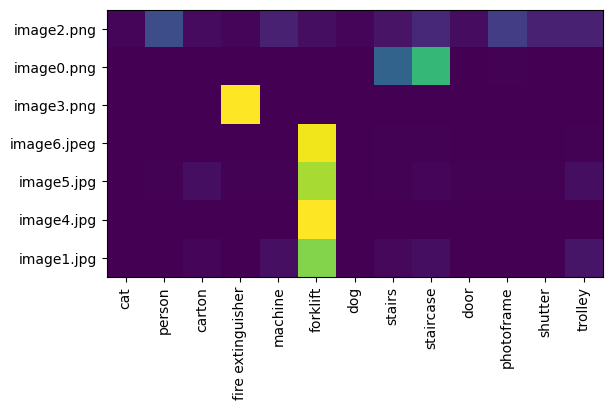

In [26]:
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

# plot the similarity matrix
plt.imshow(similarity.cpu().numpy())
plt.xticks(range(len(classes)), classes, rotation=90)
plt.yticks(range(len(images)), lst_images)